In [1]:
__author__           = "Anzal KS"
__copyright__        = "Copyright 2022-, Anzal KS"
__maintainer__       = "Anzal KS"
__email__            = "anzalks@ncbs.res.in"
from pathlib import Path
import neo.io as nio
import numpy as np
import pandas as pd
from scipy import signal as spy
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.font_manager import FontProperties
import trace_pattern_plot_x_distributed as tpp
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import multiprocessing
import time
import argparse
import math
import pdb
import seaborn

In [2]:

"""
Font and color defining functions
"""
y_labels = FontProperties()
y_labels.set_family('sans-serif')
y_labels.set_size('large')
#font.set_style('bold')

sub_titles = FontProperties()
sub_titles.set_family('sans-serif')
sub_titles.set_size('x-large')

main_title = FontProperties()
main_title.set_family('sans-serif')
main_title.set_weight('bold')
main_title.set_size('xx-large')
pre_color = "#FF0000" #pre_color blue 
post_color = "#0000FF" #post_color red 
post_late = "#00FF00" # post late green
p1_c = 'black'
p2_c = 'red'
p3_c = 'green'
pat_c = [p1_c,p2_c,p3_c]

In [3]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


In [4]:
selected_cells = '/Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp'

In [5]:
p = Path(selected_cells)

In [6]:
outdir = p/'raw_plots'
outdir.mkdir(exist_ok=True, parents=True)

In [7]:
def list_folder(p):
    f_list = []
    f_list = list(p.glob('*_cell_*'))
    f_list.sort()
    return f_list

def list_files(p):
    f_list = []
    f_list=list(p.glob('**/*abf'))
    f_list.sort()
    return f_list



In [8]:
"""
1D array and get locations with a rapid rise, N defines the rolling window
"""
def find_ttl_start(trace, N):
    data = np.array(trace)
    data -= data.min()
    data /= data.max()
    pulses = []
    for i, x in enumerate(data[::N]):
        if (i + 1) * N >= len(data):
            break
        y = data[(i+1)*N]
        if x < 0.2 and y > 0.75:
            pulses.append(i*N)
    return pulses


"""
data filter function
"""
def filter_data(data, cutoff, filt_type, fs, order=3):
    b, a = spy.butter(order, cutoff, btype = filt_type, analog=False, output='ba', fs=fs)                                                                                     
    return spy.filtfilt(b, a, data) 

"""
Convert channel names to index as an intiger
"""
def channel_name_to_index(reader, channel_name):
    for signal_channel in reader.header['signal_channels']:
        if channel_name == signal_channel[0]:
            return int(signal_channel[1])

"""
function to find the protocol name for any abf file
"""
def protocol_file_name(file_name):
    f = str(file_name)
    reader = nio.AxonIO(f)
    protocol_name = reader._axon_info['sProtocolPath']
    protocol_name = str(protocol_name).split('\\')[-1]
    protocol_name = protocol_name.split('.')[-2]
    return protocol_name
        
"""
Detects the file name with training data (LTP protocol) in it 
"""
def training_finder(f_name):
    protocol_name = protocol_file_name(f_name)
#    print(f'protocol name = {protocol_name}')
    if 'training' in protocol_name:
        f_name= f_name
    elif 'Training' in protocol_name:
        f_name = f_name
#        print(f'training {f_name}')
    else:
#        print('not training')
        f_name = None
#    print(f'out_ training prot = {f_name}')
    return f_name 

"""
Sort the list of suplied files into pre and post trainign files and return the list 
"""
def pre_post_sorted(f_list):
    found_train=False
    for f_name in f_list:
        training_f = training_finder(f_name)
#        print(f'parsed prot train = {training_f}')
        if ((training_f != None) and (found_train==False)):
            training_indx = f_list.index(training_f)
            # training indx for post will have first element as the training protocol trace
            pre = f_list[:training_indx]
            post = f_list[training_indx:]
#            pprint(f'training file - {training_f} , indx = {training_indx} '
#                f'pre file ={pre} '
#                f'post file = {post} '
#                )
            found_train = True
        elif ((training_f != None) and (found_train==True)):
            no_c_train = f_name
        else:
            pre_f_none, post_f_none, no_c_train = None, None, None
    return [pre, post, no_c_train, pre_f_none, post_f_none ]

"""
Tag protocols with training, patterns, rmp measure etc.. assign a title to the file
"""
def protocol_tag(file_name):
    protocol_name = protocol_file_name(file_name)
    if '12_points' in protocol_name:
        #print('point_protocol')
        title = 'Points'
    elif '42_points' in protocol_name:
        #print('point_protocol')
        title = 'Points'
    elif 'Baseline_5_T_1_1_3_3' in protocol_name:
        #print('pattern protocol')
        title = 'Patterns'
    elif 'patternsx' in protocol_name:
        #print('pattern protocol')
        title = 'Patterns'
    elif 'patterns_x' in protocol_name:
        #print('pattern protocol')
        title = 'Patterns'
    elif 'Training' in protocol_name:
        #print('training')
        title = 'Training pattern'
    elif 'training' in protocol_name:
        #print('training')
        title = 'Training pattern'
    elif 'RMP' in protocol_name:
        #print('rmp')
        title='rmp'
    elif 'Input_res' in protocol_name:
        #print ('InputR')
        title ='InputR'
    elif 'threshold' in protocol_name:
        #print('step_current')
        title = 'step_current'
    else:
        #print('non optical protocol')
        title = None
    return title

"""
Pair files pre and post with point, patterns, rmp etc..
"""
def file_pair_pre_pos(pre_list,post_list):
    point = []
    pattern = [] 
    rmp = []
    InputR = []
    step_current = []
    for pre in pre_list:
        tag = protocol_tag(pre)
#        print(f' tag on the file ={tag}')
        if tag=='Points':
            point.append(pre)
        elif tag=='Patterns':
            pattern.append(pre)
        elif tag =='rmp':
            rmp.append(pre)
        elif tag=='InputR':
            InputR.append(pre)
        elif tag =='step_current':
            step_current.append(pre)
        else:
            tag = None
            continue
    for post in post_list:
        tag = protocol_tag(post)
        if tag=='Points':
            point.append(post)
        elif tag=='Patterns':
            pattern.append(post)
        elif tag=='rmp':
            rmp.append(post)
        elif tag=='InputR':
            InputR.append(post)
        elif tag=='step_current':
            step_current.append(post)
        else:
            tag = None
            continue
#    print(f'point files = {point} '
#           f'pattern files = {pattern}'
#          )
    return [point, pattern,rmp, InputR, step_current]

"""
get cell trace data
"""
def cell_trace(file_name):
    f = str(file_name)
    reader = nio.AxonIO(f)
    channels =reader.header['signal_channels']
    chan_count = len(channels)
    file_id = file_name.stem
    block = reader.read_block(signal_group_mode='split-all')
    segments = block.segments
    sample_trace = segments[0].analogsignals[0]
    sampling_rate = sample_trace.sampling_rate.magnitude
    ti = sample_trace.t_start
    tf = sample_trace.t_stop
    cell_trace_all = []
    for s, segment in enumerate(segments):
        cell = channel_name_to_index(reader,'IN0')
        analogsignals = segment.analogsignals[cell]
        unit = str(analogsignals.units).split()[1]
        trace = np.array(analogsignals)
        cell_trace_all.append(trace) 
        t = np.linspace(0,float(tf-ti),len(trace))
    cell_  = (t,cell_trace_all)
#    print(cell_)
    return [cell_, sampling_rate]



In [9]:
"""
pattern label functions
"""
# plug in iteration umber and it returns a pattern type
def pat_selector(i):
    if i==0:
        pattern='Trained pattern'
    elif i==1:
        pattern='Overlapping pattern'
    elif i==2:
        pattern='Non overlapping pattern'
    else:
        pattern ='_NA'
    return pattern
def point_selector(i):
    if i<=4:
        point='Trained point'
    elif i>4:
        point='Untrained point'
    return point

In [10]:
"""
Summation functions
"""
def summate_points(array_12_points_response):
    #np.array(array_12_points_response)
    p1 = np.sum(array_12_points_response[0:5])
    p2 = np.sum(array_12_points_response[2:8])
    p3 = np.sum(array_12_points_response[8:-1])
    p =[p1,p2,p3]
    return p

In [11]:
"""
Analysis functions
"""
"""
Get peak events by taking TTL into account
"""
def peak_event(file_name,channel_name):
    f = str(file_name)
    reader = nio.AxonIO(f)
    channels = reader.header['signal_channels']
    chan_count = len(channels)
    file_id = file_name.stem
    block  = reader.read_block(signal_group_mode='split-all')
    segments = block.segments
    sample_trace = segments[0].analogsignals[0]
    sampling_rate = sample_trace.sampling_rate.magnitude
    ti = sample_trace.t_start
    tf = sample_trace.t_stop
    cell_trace_all = []
    TTL_sig_all = []
    for s, segment in enumerate(segments):
        cell = channel_name_to_index(reader,channel_name)
        analogsignals = segment.analogsignals[cell]
        unit = str(analogsignals.units).split()[1]
        trace = np.array(analogsignals)
        cell_trace_all.append(trace) 
        t = np.linspace(0,float(tf-ti),len(trace))
#    print (f'IN0 = {cell_trace_all}')
    for s, segment in enumerate(segments):
        cell = channel_name_to_index(reader,'FrameTTL')
        analogsignals = segment.analogsignals[cell]
        unit = str(analogsignals.units).split()[1]
        trace = np.array(analogsignals)
        TTL_sig_all.append(trace) 
        t = np.linspace(0,float(tf-ti),len(trace))
#    print (f' TTL = {TTL_sig_all}')
    ttl_av = np.average(TTL_sig_all,axis=0 )
    ttl_xi= find_ttl_start(ttl_av, 3)
    ttl_xf = (ttl_xi+0.075*sampling_rate).astype(int)
    bl_xf = (ttl_xi-0.005*sampling_rate).astype(int)
    bl_xi = (bl_xf-0.01*sampling_rate).astype(int)
    cell_trace  = np.average(cell_trace_all, axis =0)
    cell_trace_base_line = np.mean(cell_trace[0:int(0.2*sampling_rate)] )
    cell_trace_av = cell_trace - cell_trace_base_line
    cell_trace_b_sub = cell_trace_all-cell_trace_base_line
    event_av = []
    events = []
    pat_trace =[]
    t_pat_trace =[]
    for i,ti in enumerate(ttl_xi): 
        event_av.append(np.max(cell_trace_av[ttl_xi[i]:ttl_xf[i]]))
        pattern = []
        pt_trace = []
        for n, ni in enumerate(cell_trace_all):
            r_t =ni[ttl_xi[i]:ttl_xf[i]]
            b_l = np.mean(ni[bl_xi[i]:bl_xf[i]],axis=0)
            bl_t = ni[bl_xi[i]:bl_xf[i]]-b_l
            p_t = r_t-b_l
            pat_t = ni[bl_xi[i]:ttl_xf[i]]
            pt_trace.append(pat_t)
            pt_max = np.max(p_t)
            t_pat_trace.append(pt_max)
            pattern.append(pt_max)
        events.append(pattern)
        pat_trace.append(pt_trace)
    #print(f'peak_event worked, events ={events}')
    return [event_av, events,pat_trace]



"""
Raw epsp response amplitude values 
"""

def raw_peak_dist(points_or_pattern_file_set_abf):
    global epsp_post_raw
    pre_f = points_or_pattern_file_set_abf[0]
    post_f = points_or_pattern_file_set_abf[1:]
    epsp_pre_av = peak_event(pre_f,'IN0')[0]
    epsp_pre = peak_event(pre_f,'IN0')[1] #IN0 for cell channel
    epsp_pre_raw = peak_event(pre_f,'IN0')[2] #IN0 for cell channel
    epsp_post_av = []
    epsp_post = []
    epsp_post_raw = []
    for p in post_f:
        epsp_post_raw.append(peak_event(p,'IN0')[2]) #IN0 for cell channel
        epsp_post.append(peak_event(p,'IN0')[1]) #IN0 for cell channel
        epsp_post_av.append(peak_event(p,'IN0')[0]) #IN0 for cell channel
    epsp_raw = [epsp_pre_raw,epsp_post_raw]
    epsp_pre = [epsp_pre_av,epsp_pre]
    epsp_post = [epsp_post_av,epsp_post]
    epsp_events = [epsp_pre,epsp_post,epsp_raw]
    #print(f'raw_peak_dist_worked')
    return epsp_events


"""
Field response amplitudes
"""
def raw_field_dist(points_or_pattern_file_set_abf):
    global epsp_post_raw
    pre_f = points_or_pattern_file_set_abf[0]
    post_f = points_or_pattern_file_set_abf[1:]
    epsp_pre = peak_event(pre_f,'Field')[1] #IN0 for cell channel

    epsp_pre_raw = peak_event(pre_f,'Field')[2] #IN0 for cell channel
    epsp_post = []
    epsp_post_raw = []
    for p in post_f:
        epsp_post_raw.append(peak_event(p,'Field')[2]) #IN0 for cell channel
        epsp_post.append(peak_event(p,'Field')[1]) #IN0 for cell channel
    epsp_raw = [epsp_pre_raw,epsp_post_raw]
    epsp_events = [epsp_pre,epsp_post,epsp_raw]
    #print(f'raw_peak_dist_worked')
    return epsp_events
        
    
    

In [12]:
"""
single cell functions
"""
"""
pair pre and post, points and patterns for each cell.
"""
def file_pair(cell_path): 
    cell_id = str(cell_path.stem)
    abf_list = list_files(cell_path)
    sorted_f_list = pre_post_sorted(abf_list)
    pre_f_list = sorted_f_list[0]
    post_f_list = sorted_f_list[1][1:]
    training_f = sorted_f_list[1][0]
    no_c_train = sorted_f_list[2]
    paired_list = file_pair_pre_pos(pre_f_list, post_f_list)
    paired_points = paired_list[0]
    paired_patterns = paired_list[1]
    return [paired_points,paired_patterns]


"""
series resistance changes for X distributed patterns
"""

def series_res_cell(cell_path):
    files_paired = file_pair(cell_path)
    points,patterns = files_paired[0],files_paired[1]
    point_pre, point_post = points[0],points[1]
    pattern_pre,pattern_post =patterns[0],patterns[1]
    sampling_rate = cell_trace(point_pre)[1]
    protocol_name = protocol_file_name(point_pre)
#    print(f'protocol name = {protocol_name}')
    if '42_points' in protocol_name:
        points_t_start, points_t_end = 11.8,12.225
        pattern_t_start, pattern_t_end =11.4,11.7        
    elif '12_points' in protocol_name:
        points_t_start, points_t_end = 4.0,4.55
        pattern_t_start, pattern_t_end =8.4,8.75
    else:
        print(f'something off with protocol file name')
    injected_current = current_injected(point_pre)
    series_r_point_pre = series_res_measure(point_pre,injected_current,points_t_start,points_t_end,sampling_rate)
    series_r_point_post = series_res_measure(point_post,injected_current,points_t_start,points_t_end,sampling_rate)
    series_r_pattern_pre = series_res_measure(pattern_pre,injected_current,pattern_t_start,pattern_t_end,sampling_rate)
    series_r_pattern_post = series_res_measure(pattern_post,injected_current,pattern_t_start,pattern_t_end,sampling_rate)
    series_r_point = [series_r_point_pre,series_r_point_post]
    series_r_patern = [series_r_pattern_pre,series_r_pattern_post]
    series_r = [series_r_point,series_r_patern]
    return series_r

"""
pickup the changes in series resistances across recordings in the cell.
returns the difference in series resistance change across different protocols
give a percentage change from begining to end of the protocol.
"""
def series_r_shift(cell_path):
    series_r=series_res_cell(cell_path)
    point_pre = series_r[0][0]
    point_pre_mean = np.mean(point_pre)
    point_post = series_r[0][1]
    point_post_mean = np.mean(point_post)
    pattern_pre = series_r[1][0]
    pattern_pre_mean = np.mean(pattern_pre)
    pattern_post = series_r[1][1]
    pattern_post_mean = np.mean(pattern_post)
    point_sr_diff = point_post_mean-point_pre_mean
    pattern_sr_diff = pattern_post_mean-pattern_pre_mean
    cel_sr_diff= point_post_mean-point_pre_mean # first and last protocol is point based.
    pec_change = np.around((((np.abs(cel_sr_diff))/np.abs(point_pre_mean))*100),2)
    sr_diff = np.abs([point_sr_diff,pattern_sr_diff,cel_sr_diff])
    return [sr_diff,pec_change]

"""
take in the cell path and list down the Vms for different files
"""

def vm_shift_cell(cell_path):
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    vm_shift_points_pre = vm_shift(points[0])
    vm_shift_points_post = vm_shift(points[1])
    vm_shift_patterns_pre = vm_shift(patterns[0])
    vm_shift_patterns_post = vm_shift(patterns[1])
    vm_s_point = [vm_shift_points_pre,vm_shift_points_post]
    vm_s_pattern = [vm_shift_patterns_pre,vm_shift_patterns_post]
    vm_s_cell = np.mean(np.abs(vm_shift_points_post-vm_shift_points_pre))
    return vm_s_cell

"""
Take in cell path and calculate the amount of plasticity: percentage increase
in amplitude.
"""
def plasticity_test_cell(cell_path):
    global raw_pattern_pre
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points = raw_peak_dist(points)
    epsps_points_pre = epsps_points[0][1]
    epsps_points_post = epsps_points[1][1]
    #raw_points_pre = epsps_points[2][0]
    #raw_points_post = epsps_points[2][1]
    raw_points =[epsps_points_pre,epsps_points_post]
    #print(f'for points epsp pre = {epsps_points_pre},##### epsp post = {epsps_points_post}')
    change_epsp_point = np.mean(epsps_points_post,axis=0)-np.mean(epsps_points_pre,axis=0)
    perc_change_point = np.around(((change_epsp_point/np.mean(epsps_points_pre,axis=0))*100),1)
    #print(f' point change= {perc_change_point}')
    
    epsps_patterns = raw_peak_dist(patterns)
    epsps_patterns_pre = epsps_patterns[0][1]
    epsps_patterns_post = epsps_patterns[1][1]
    raw_pattern_pre = epsps_patterns[2][0]
    #raw_pattern_post = epsps_patterns[2][1]
    raw_patterns = [epsps_patterns_pre,epsps_patterns_post]
    #print(f'for points epsp pre = {epsps_patterns_pre},##### epsp post = {epsps_patterns_post}')
    change_epsp_pattern = np.mean(epsps_patterns_post,axis=0)-np.mean(epsps_patterns_pre,axis=0)
    perc_change_pattern = np.around(((change_epsp_pattern/np.mean(epsps_patterns_pre,axis=0))*100),1)
    #print(f'pattern change = {perc_change_pattern}')

    epsp_per = [perc_change_point,perc_change_pattern,raw_points,raw_patterns]
    return epsp_per

"""
patterns summation for points pre and last time point.
"""
def pat_vs_sum_points(cell_path):
    f_name = cell_path.stem
    files_paired = file_pair(cell_path)
    points= files_paired[0]
    patterns= files_paired[1]
    raw_peaks_points_pre,raw_peaks_points_post = raw_peak_dist(points)[0][0],raw_peak_dist(points)[1][0][-1]
    raw_peaks_pattern_pre,raw_peaks_pattern_post =raw_peak_dist(patterns)[0][0],raw_peak_dist(patterns)[1][0][-1]
    
    sum_points_pre = summate_points(raw_peaks_points_pre)
    sum_points_post = summate_points(raw_peaks_points_post)
    pattern_pre =[raw_peaks_pattern_pre,sum_points_pre]
    pattern_post=[raw_peaks_pattern_post,sum_points_post]
    pat = [pattern_pre,pattern_post]
    return pat

"""
classic LTP points 
"""
def classic_ltp_patterns_average(cell_path):
    f_name = cell_path.stem
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points_pre = raw_peak_dist(points)[0][0]
    epsps_points_post = raw_peak_dist(points)[1][0]
    
    epsps_patterns_pre = raw_peak_dist(patterns)[0][0]
    epsps_patterns_post = raw_peak_dist(patterns)[1][0]
    pat_0min = np.array(epsps_patterns_post[0])
    #epsps_patterns_post = np.array(epsps_patterns_post)/np.array(epsps_patterns_post[0])
    epsps_patterns_pre = list(np.array(epsps_patterns_pre)/pat_0min)
    
    t= np.arange(0.1,len(epsps_patterns_pre),0.1)
    t_pre=t-10
        
    #plt.plot(t,epsps_patterns_pre,color=colorFader(post_color,post_late,0/len(epsps_patterns_pre)))
    
    for i,i_ in enumerate(epsps_patterns_pre):
        #i_=(np.array(i_)/np.array(epsps_patterns_post[0][i]))
        plt.scatter(t_pre[i],i_,color=pat_c[i], label=pat_selector(i),alpha=0.8)
    
    #for i,i_ in enumerate(epsps_patterns_pre):
    #   plt.axhline(i_, color=pat_c[i],alpha=0.5, linestyle='--',label=f'{pat_selector(i)} baseline')    
    
    for p,pi in enumerate(epsps_patterns_post):
        pi = list(np.array(pi)/np.array(epsps_patterns_post[0]))
        t= np.arange(0.1,len(epsps_patterns_pre),0.1)
        t_post=t+10*p
        #plt.plot(t,pi,color=colorFader(post_color,post_late,p/len(pi)))
        for i,i_ in enumerate(pi):
            #i_=(np.array(i_)/np.array(epsps_patterns_pre[0][i]))
            plt.scatter(t_post[i],i_,color=pat_c[i],label='_nolabel', alpha=0.8)
    
    plt.axvline(-1, color='k',linewidth=2,label='LTP induction')
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 2)
    plt.xlabel('time (min)')
    plt.ylabel('cell Response normalised with 0min response')
    #plt.ylabel('cell Response (mV)')
    plt.title(f'average response for patterns: {f_name}')
    plt.tight_layout()
    plt.savefig(f'{outdir}_classic_LTP_average_patterns_norm_0min.png',bbox_inches='tight')    
    plt.show()
    plt.close()

In [13]:
"""
Functions used across cells
"""



'\nFunctions used across cells\n'

In [14]:
"""
Plot all cells from pattern vs points summated 
"""
def plot_pat_vs_sum_p_cells(cells,outdir):
    for ci,c in enumerate(cells):
        try:
            pat = pat_vs_sum_points(c)
            pat_pre,pat_post=pat[0],pat[1]
            pat_pre_pat=pat_pre[0]
            pat_pre_sum=pat_pre[1]
            pat_post_pat=pat_post[0]
            pat_post_sum=pat_post[1]
            if ci==0:
                for i,i_ in enumerate(pat_pre_pat):
                    plt.scatter(pat_pre_sum[i],pat_pre_pat[i],color=pat_c[i], label=f'{pat_selector(i)}_pre', alpha =0.5)
                    plt.scatter(pat_post_sum[i],pat_post_pat[i],color=pat_c[i], label=f'{pat_selector(i)}_post')
            else:
                for i,i_ in enumerate(pat_pre_pat):
                    plt.scatter(pat_pre_sum[i],pat_pre_pat[i],color=pat_c[i], label='_none', alpha =0.5)
                    plt.scatter(pat_post_sum[i],pat_post_pat[i],color=pat_c[i], label='_none')
        except Exception as e: print(e)
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 3,title='frames: patterns')        
    plt.title(f'pattern vs summation of points {len(cells)} cells stacked')    
    plt.xlim(-1,12)
    plt.ylim(-1,12)
    plt.axline([0, 0], [1, 1])
    plt.xlabel('summated response to points (mV)')
    plt.ylabel('response to patterns (mV)')
    plt.savefig(f'{outdir}/pat_vs_sum_points_pre_vs_40min_all_cells.png',bbox_inches='tight') 
    plt.show()
    plt.close()

"""
plot all 0min normalised classic ltp
"""
def ltp_average_cell_Stack(cells,outdir):
    global f_
    fig_size = (10, 5)
    fig_pl = plt.figure(figsize=fig_size)
    f_ = []
    for c in cells:
        try:
            g= classic_ltp_plot_patterns_average_overlay(c,outdir,fig_pl)
            f_.append(g)
        except Exception as e: print(e)
        g
    plt.axvline(-1, color='k',linewidth=2,label='LTP induction')
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 2)
    plt.xlabel('time (min)')
    plt.ylabel('cell Response normalised with 0min response')
    #plt.ylabel('cell Response (mV)')
    plt.title(f'average response for patterns {len(cells)} combined')
    plt.tight_layout()
    plt.savefig(f'{outdir}/_classic_LTP_average_patterns_norm_0min_cell_stack.png',bbox_inches='tight')
    plt.show()

In [15]:
"""
for i,i_ in enumerate(epsps_patterns_pre):
        #i_=(np.array(i_)/np.array(epsps_patterns_post[0][i]))
        plt.scatter(t_pre[i],i_,color=pat_c[i], label=pat_selector(i),alpha=0.8)
    
    #for i,i_ in enumerate(epsps_patterns_pre):
    #   plt.axhline(i_, color=pat_c[i],alpha=0.5, linestyle='--',label=f'{pat_selector(i)} baseline')    
    
    for p,pi in enumerate(epsps_patterns_post):
        pi = list(np.array(pi)/np.array(epsps_patterns_post[0]))
        t= np.arange(0.1,len(epsps_patterns_pre),0.1)
        t_post=t+10*p
        #plt.plot(t,pi,color=colorFader(post_color,post_late,p/len(pi)))
        for i,i_ in enumerate(pi):
            #i_=(np.array(i_)/np.array(epsps_patterns_pre[0][i]))
            plt.scatter(t_post[i],i_,color=pat_c[i],label='_nolabel', alpha=0.8)
    
    plt.axvline(-1, color='k',linewidth=2,label='LTP induction')
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 2)
    plt.xlabel('time (min)')
    plt.ylabel('cell Response normalised with 0min response')
    #plt.ylabel('cell Response (mV)')
    plt.title(f'average response for patterns: {f_name}')
    plt.tight_layout()
    plt.savefig(f'{outdir}_classic_LTP_average_patterns_norm_0min.png',bbox_inches='tight')    
    plt.show()
    plt.close()
"""

"\nfor i,i_ in enumerate(epsps_patterns_pre):\n        #i_=(np.array(i_)/np.array(epsps_patterns_post[0][i]))\n        plt.scatter(t_pre[i],i_,color=pat_c[i], label=pat_selector(i),alpha=0.8)\n    \n    #for i,i_ in enumerate(epsps_patterns_pre):\n    #   plt.axhline(i_, color=pat_c[i],alpha=0.5, linestyle='--',label=f'{pat_selector(i)} baseline')    \n    \n    for p,pi in enumerate(epsps_patterns_post):\n        pi = list(np.array(pi)/np.array(epsps_patterns_post[0]))\n        t= np.arange(0.1,len(epsps_patterns_pre),0.1)\n        t_post=t+10*p\n        #plt.plot(t,pi,color=colorFader(post_color,post_late,p/len(pi)))\n        for i,i_ in enumerate(pi):\n            #i_=(np.array(i_)/np.array(epsps_patterns_pre[0][i]))\n            plt.scatter(t_post[i],i_,color=pat_c[i],label='_nolabel', alpha=0.8)\n    \n    plt.axvline(-1, color='k',linewidth=2,label='LTP induction')\n    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 2)\n    plt.xlabel('time (min)')\n    plt.yla

In [16]:


    
"""
event plotting feild
"""
def field_raw_trace_plot(cell_path,outdir):
    #global sp_n
    #global raw_points_post
    f_name = cell_path.stem
    outdir = f'{outdir}/{f_name}'
    print(f' out for save = {outdir}')
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points = raw_field_dist(points)
    raw_points_pre = epsps_points[2][0]
    raw_points_post = epsps_points[2][1]

    
    epsps_patterns = raw_field_dist(patterns)
    raw_pattern_pre = epsps_patterns[2][0]
    raw_pattern_post = epsps_patterns[2][1]
    
    #plot epsps pre vs post ptterns
    sp_n = np.shape(raw_pattern_pre)[0]
    sp_n = int(math.ceil(sp_n / 2) * 2)
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for non_x
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for x speard patterns
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (8,4)) #for x speard 0.2Hz
    
    axs=axs.flatten()
    
    for p,i in enumerate(raw_pattern_pre):
        for n,x in enumerate(i):
            bl = np.mean(x[100:300])
            x = x-bl
            if ((p+1==len(raw_pattern_pre))and(n+1==len(i))):
                axs[p].plot(x,color=pre_color, label='pre training')
            else:
                axs[p].plot(x,color=pre_color)

    for a,b in enumerate(raw_pattern_post):
        for p,i in enumerate(b):
            for n,x in enumerate(i):
                bl = np.mean(x[100:300])
                x = x-bl
                #print(bl)
                if n+1==len(i):
                    #t_label =f'time = {((a+1)*5)-5} mins'# for 5 min interval measurements
                    t_label =f'time = {((a+1)*10)-10} mins'# for 5 min interval measurements
                else:
                    t_label='_nolegend_'
                #axs[p].plot(x,color=f'C{a}',alpha=0.5, label=t_label)
                axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.2)
                if p+1==len(b):
                    axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.3,label=t_label)
                else:
                    continue
            axs[p].set_xlim(100,700)
            axs[p].set_ylabel('mV')
            if p==0:
                axs[p].set_title(f'frame no = {p+1} (trained pattern)')
            else:
                axs[p].set_title(f'frame no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'Field response for patterns: {cell_path.stem}')
    plt.tight_layout()
    plt.savefig(f'{outdir}_field_raw_trace_pattern.png',bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)
    
    #plot epsps pre vs post  points
    sp_n = np.shape(raw_points_pre)[0]
    sp_n = int((math.ceil(sp_n/2))*2)
    print(f' sp = {sp_n}')
    #fig, axs = plt.subplots(5,int(sp_n/4), figsize = (15,7)) # for non x_spread
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (6,3),layout="constrained") # for x_spread
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,3),layout="constrained") #for x speard 0.2Hz
    axs=axs.flatten()
    
    for p,i in enumerate(raw_points_pre):
        for n,x in enumerate(i):
            bl = np.mean(x[100:200])# for 10k sampling
            x = x-bl
            if ((p+1==len(raw_pattern_pre))and(n+1==len(i))):
                axs[p].plot(x,color=pre_color, label='pre training')
            else:
                axs[p].plot(x,color=pre_color)

    for a,b in enumerate(raw_points_post):
        for p,i in enumerate(b):
            for n,x in enumerate(i):
                bl = np.mean(x[100:200])# for 10k sampling
                x = x-bl
                #print(bl)
                if n+1==len(i):
                    #t_label =f'time = {((a+1)*5)-5} mins' # for 5 min interval measurements
                    t_label =f'time = {((a+1)*10)-10} mins' # for 10min interval measurements
                else:
                    t_label='_nolegend_'
                #axs[p].plot(x,color=f'C{a}',alpha=0.5, label=t_label)
                axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.2)
                if p+1==len(b):
                    axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.2,label=t_label)
                else:
                    continue
            #axs[p].set_xlim(50,400) #for 10k sampling
            axs[p].set_xlim(100,700) #for 20k sampling
            axs[p].set_ylabel('mV')
            if p<=4:
                axs[p].set_title(f'fr no = {p+1} (tp)')
            else:
                axs[p].set_title(f'fr no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'Field response for points: {cell_path.stem}')
    #plt.tight_layout()#rect=[0, 0.03, 1, 0.95])#pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig(f'{outdir}_field_raw_trace_points.png',bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)   
    raw_pattern_pre_plot =raw_pattern_pre
    return 


In [17]:
def field_trace_average_plot(cell_path,outdir):
    #global sp_n
    #global raw_points_post
    f_name = cell_path.stem
    outdir = f'{outdir}/{f_name}'
    print(f' out for save = {outdir}')
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points = raw_field_dist(points)
    raw_points_pre = epsps_points[2][0]
    raw_points_post = epsps_points[2][1]

    
    epsps_patterns = raw_field_dist(patterns)
    raw_pattern_pre = epsps_patterns[2][0]
    raw_pattern_post = epsps_patterns[2][1]
    
    #plot epsps pre vs post ptterns
    sp_n = np.shape(raw_pattern_pre)[0]
    sp_n = int(math.ceil(sp_n / 2) * 2)
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for non_x 
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for x speard patterns
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (6,4)) #for x speard 0.2Hz
    
    axs=axs.flatten()
    
    for p,i in enumerate(raw_pattern_pre):
        trace_av = []
        for n,x in enumerate(i):
            trace_av.append(x)
        trace_av = np.mean(trace_av,axis=0)    
        bl = np.mean(trace_av[100:300])
        trace_av= trace_av-bl
        if p+1==len(raw_pattern_pre):
            axs[p].plot(trace_av,color=pre_color, label ='Pre training')
        else:
            axs[p].plot(trace_av,color=pre_color)

    for a,b in enumerate(raw_pattern_post):
        for p,i in enumerate(b):
            trace_av = []
            for n,x in enumerate(i):
                trace_av.append(x)
            if p+1==len(b):
                #t_label =f'time = {((a+1)*5)-5} mins'
                t_label =f'time = {((a+1)*10)-10} mins'
            else:
                t_label='_nolegend_'
            y =np.mean(trace_av,axis=0)
            bl = np.mean(y[100:300])
            y = y-bl
            if p+1==len(b):
                #t_label =f'time = {((a+1)*5)-5} mins' # for 5min interval measurements
                t_label =f'time = {((a+1)*10)-10} mins' # for 10min interval measurements
                #axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
            else:
                t_label='_nolegend_'
            axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
                #continue
            axs[p].set_xlim(100,700)
            axs[p].set_ylabel('mV')
            if p==0:
                axs[p].set_title(f'frame no = {p+1} (trained pattern)')
            else:
                axs[p].set_title(f'frame no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'average field response for patterns: {cell_path.stem}')
    plt.tight_layout()
    plt.savefig(f'{outdir}_field_average_trace_pattern.png',bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)
    
    #plot epsps pre vs post  points
    sp_n = np.shape(raw_points_pre)[0]
    sp_n = int((math.ceil(sp_n/2))*2)
    print(f' sp = {sp_n}')
    #fig, axs = plt.subplots(5,int(sp_n/4), figsize = (15,7)) # for non x_spread
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,3),layout="constrained") # for x_spread
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,3),layout="constrained") #for x speard 0.2Hz
    axs=axs.flatten()
    
    for p,i in enumerate(raw_points_pre):
        trace_av = []
        for n,x in enumerate(i):
            trace_av.append(x)
        trace_av = np.mean(trace_av,axis=0)    
        bl = np.mean(trace_av[100:200]) # for 10k sampling
        trace_av= trace_av-bl
        if p+1==len(raw_pattern_pre):
            axs[p].plot(trace_av,color=pre_color, label ='Pre training')
        else:
            axs[p].plot(trace_av,color=pre_color)

    for a,b in enumerate(raw_points_post):
        for p,i in enumerate(b):
            trace_av = []
            for n,x in enumerate(i):
                trace_av.append(x)
            if p+1==len(b):
                #t_label =f'time = {((a+1)*5)-5} mins'
                t_label =f'time = {((a+1)*10)-10} mins'
            else:
                t_label='_nolegend_'
            y =np.mean(trace_av,axis=0)
            bl = np.mean(y[100:200]) # for 10k sampling
            y = y-bl
            if p+1==len(b):
                #t_label =f'time = {((a+1)*5)-5} mins' #for 5 min interval measurements.
                t_label =f'time = {((a+1)*10)-10} mins' # for 10min interval measurements
                #axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
            else:
                t_label='_nolegend_'
            axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
            #axs[p].set_xlim(50,400) #for 10K sampling
            axs[p].set_xlim(100,700) #for 20k sampling
            axs[p].set_ylabel('mV')
            if p<=4:
                axs[p].set_title(f'fr no = {p+1} (tp)')
            else:
                axs[p].set_title(f'fr no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'average field response for points: {cell_path.stem}')
    plt.tight_layout()#rect=[0, 0.03, 1, 0.95])#pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig(f'{outdir}_field_average_trace_points.png',bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)   
    raw_pattern_pre_plot =raw_pattern_pre
    return 


In [18]:

    
"""
event plotting cell
"""
def cell_raw_trace_plot(cell_path,outdir):
    #global sp_n
    #global raw_points_post
    f_name = cell_path.stem
    outdir = f'{outdir}/{f_name}'
    print(f' out for save = {outdir}')
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points = raw_peak_dist(points)
    raw_points_pre = epsps_points[2][0]
    raw_points_post = epsps_points[2][1]

    
    epsps_patterns = raw_peak_dist(patterns)
    raw_pattern_pre = epsps_patterns[2][0]
    raw_pattern_post = epsps_patterns[2][1]
    
    #plot epsps pre vs post ptterns
    sp_n = np.shape(raw_pattern_pre)[0]
    sp_n = int(math.ceil(sp_n / 2) * 2)
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for non_x
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for x speard patterns
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (6,4)) #for x speard 0.2Hz
    
    axs=axs.flatten()
    
    for p,i in enumerate(raw_pattern_pre):
        for n,x in enumerate(i):
            bl = np.mean(x[100:300])
            x = x-bl
            if ((p+1==len(raw_pattern_pre))and(n+1==len(i))):
                axs[p].plot(x,color=pre_color, label='pre training')
            else:
                axs[p].plot(x,color=pre_color)

    for a,b in enumerate(raw_pattern_post):
        for p,i in enumerate(b):
            for n,x in enumerate(i):
                bl = np.mean(x[100:300])
                x = x-bl
                #print(bl)
                if n+1==len(i):
                    #t_label =f'time = {((a+1)*5)-5} mins'# for 5 min interval measurements
                    t_label =f'time = {((a+1)*10)-10} mins'# for 5 min interval measurements
                    
                else:
                    t_label='_nolegend_'
                #axs[p].plot(x,color=f'C{a}',alpha=0.5, label=t_label)
                axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.3)
                if p+1==len(b):
                    axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.3,label=t_label)
                else: 
                    continue
            axs[p].set_ylabel('mV')
            if p==0:
                axs[p].set_title(f'frame no = {p+1} (trained pattern)')
            else:
                axs[p].set_title(f'frame no = {p+1}')            
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'cell raw response for patterns: {cell_path.stem}')
    plt.tight_layout()
    plt.savefig(f'{outdir}_cell_raw_trace_pattern.png',bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)
    
    #plot epsps pre vs post  points
    sp_n = np.shape(raw_points_pre)[0]
    sp_n = int((math.ceil(sp_n/2))*2)
    print(f' sp = {sp_n}')
    #fig, axs = plt.subplots(5,int(sp_n/4), figsize = (15,7)) # for non x_spread
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,3),layout="constrained") # for x_spread
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,3),layout="constrained") #for x speard 0.2Hz
    axs=axs.flatten()
    
    for p,i in enumerate(raw_points_pre):
        for n,x in enumerate(i):
            bl = np.mean(x[100:200])# for 10k sampling
            x = x-bl
            if ((p+1==len(raw_pattern_pre))and(n+1==len(i))):
                axs[p].plot(x,color=pre_color, label='pre training')
            else:
                axs[p].plot(x,color=pre_color)

    for a,b in enumerate(raw_points_post):
        for p,i in enumerate(b):
            for n,x in enumerate(i):
                bl = np.mean(x[100:200])# for 10k sampling
                x = x-bl
                #print(bl)
                if n+1==len(i):
                    #t_label =f'time = {((a+1)*5)-5} mins' # for 5 min interval measurements
                    t_label =f'time = {((a+1)*10)-10} mins' # for 10min interval measurements
                else:
                    t_label='_nolegend_'
                #axs[p].plot(x,color=f'C{a}',alpha=0.5, label=t_label)
                axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.3)
                if p+1==len(b):
                    axs[p].plot(x,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.3,label=t_label)
                else:
                    continue
            axs[p].set_ylabel('mV')
            if p<=4:
                axs[p].set_title(f'fr no = {p+1} (tp)')
            else:
                axs[p].set_title(f'fr no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'cell raw response for points: {cell_path.stem}')
    plt.tight_layout()#rect=[0, 0.03, 1, 0.95])#pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig(f'{outdir}_cell_raw_trace_points.png',bbox_inches='tight')    
    plt.show(fig)
    plt.close(fig)   
    raw_pattern_pre_plot =raw_pattern_pre 


In [348]:
def cell_raw_trace_average_plot(cell_path,outdir):
    #global sp_n
    #global raw_points_post
    f_name = cell_path.stem
    outdir = f'{outdir}/{f_name}'
    print(f' out for save = {outdir}')
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points = raw_peak_dist(points)
    raw_points_pre = epsps_points[2][0]
    raw_points_post = epsps_points[2][1]

    
    epsps_patterns = raw_peak_dist(patterns)
    raw_pattern_pre = epsps_patterns[2][0]
    raw_pattern_post = epsps_patterns[2][1]
    
    #plot epsps pre vs post ptterns
    sp_n = np.shape(raw_pattern_pre)[0]
    sp_n = int(math.ceil(sp_n / 2) * 2)
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for non_x 
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,4)) #for x speard patterns
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (6,4)) #for x speard 0.2Hz
    
    axs=axs.flatten()
    
    for p,i in enumerate(raw_pattern_pre):
        trace_av = []
        for n,x in enumerate(i):
            trace_av.append(x)
        trace_av = np.mean(trace_av,axis=0)    
        bl = np.mean(trace_av[100:300])
        trace_av= trace_av-bl
        if p+1==len(raw_pattern_pre):
            axs[p].plot(trace_av,color=pre_color, label ='Pre training')
        else:
            axs[p].plot(trace_av,color=pre_color)

    for a,b in enumerate(raw_pattern_post):
        for p,i in enumerate(b):
            trace_av = []
            for n,x in enumerate(i):
                trace_av.append(x)
            if p+1==len(b):
                #t_label =f'time = {((a+1)*5)-5} mins'
                t_label =f'time = {((a+1)*10)-10} mins'
            else:
                t_label='_nolegend_'
            y =np.mean(trace_av,axis=0)
            bl = np.mean(y[100:300])
            y = y-bl
            if p+1==len(b):
                #t_label =f'time = {((a+1)*5)-5} mins' # for 5min interval measurements
                t_label =f'time = {((a+1)*10)-10} mins' # for 10min interval measurements
            else:
                t_label='_nolegend_'
            axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
            axs[p].set_ylabel('mV')
            #axs[p].set_xlim(0,1500)
            if p==0:
                axs[p].set_title(f'frame no = {p+1} (trained pattern)')
            else:
                axs[p].set_title(f'frame no = {p+1}')
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'Cell average response for patterns: {cell_path.stem}')
    plt.xlabel=('sample points(@20KHz sampling)')
    plt.tight_layout()
    plt.savefig(f'{outdir}_cell_average_trace_patterns.png',bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)
    
    #plot epsps pre vs post  points
    sp_n = np.shape(raw_points_pre)[0]
    sp_n = int((math.ceil(sp_n/2))*2)
    print(f' sp = {sp_n}')
    #fig, axs = plt.subplots(5,int(sp_n/4), figsize = (15,7)) # for non x_spread
    #fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,3),layout="constrained") # for x_spread
    fig, axs = plt.subplots(2,int(sp_n/2), figsize = (12,3),layout="constrained") #for x speard 0.2Hz
    axs=axs.flatten()
    
    for p,i in enumerate(raw_points_pre):
        trace_av = []
        for n,x in enumerate(i):
            trace_av.append(x)
        trace_av = np.mean(trace_av,axis=0)    
        bl = np.mean(trace_av[100:200]) # for 10k sampling
        trace_av= trace_av-bl
        if p+1==len(raw_pattern_pre):
            axs[p].plot(trace_av,color=pre_color, label ='Pre training')
        else:
            axs[p].plot(trace_av,color=pre_color)

    for a,b in enumerate(raw_points_post):
        for p,i in enumerate(b):
            trace_av = []
            for n,x in enumerate(i):
                trace_av.append(x)
            if p+1==len(b):
                #t_label =f'time = {((a+1)*5)-5} mins'
                t_label =f'time = {((a+1)*10)-10} mins'
            else:
                t_label='_nolegend_'
            y =np.mean(trace_av,axis=0)
            bl = np.mean(y[100:200]) # for 10k sampling
            y = y-bl
            if p+1==len(b):
                #t_label =f'time = {((a+1)*5)-5} mins' #for 5 min interval measurements.
                t_label =f'time = {((a+1)*10)-10} mins' # for 10min interval measurements
            else:
                t_label='_nolegend_'
            axs[p].plot(y,color=colorFader(post_color,post_late,a/len(raw_points_post)),alpha=0.8,label=t_label)
            axs[p].set_ylabel('mV')
            if p<=4:
                axs[p].set_title(f'fr no = {p+1} (tp)')
            else:
                axs[p].set_title(f'fr no = {p+1}')
            #axs[p].set_xlim(200,700)            
            if ((a+1==int(len(raw_pattern_post)))and (p+1==len(b))):
                fig.legend(loc='upper center',bbox_to_anchor =(0.5, -0.02), ncol = 4)
            else:
                continue
    plt.suptitle(f'Average response for points: {cell_path.stem}')
    plt.tight_layout()#rect=[0, 0.03, 1, 0.95])#pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig(f'{outdir}_cell_average_trace_points.png',bbox_inches='tight')    
    plt.show(fig)
    plt.close(fig)   
    raw_pattern_pre_plot =raw_pattern_pre 


In [20]:
def plot_raw(f):
    f = str(f)
    reader = nio.AxonIO(f)
    channels = reader.header['signal_channels']
    chan_count = len(channels)
    block  = reader.read_block(signal_group_mode='split-all')
    segments = block.segments
    sample_trace = segments[0].analogsignals[0]
    sampling_rate = sample_trace.sampling_rate
    ti = sample_trace.t_start
    tf = sample_trace.t_stop
    total_time = int(tf-ti)
    protocol_raw = reader.read_raw_protocol()
    protocol_raw = protocol_raw[0]
    print(total_time)
    unit = str(sample_trace.units).split()[1]
#        print(unit)
    fig, axs = plt.subplots(chan_count,2,figsize=(15,6),sharex='col')
    for i in range(chan_count):
        trace_average = []
        for s, segment in enumerate(segments):
            analogsignals = segment.analogsignals[i]
            unit = str(analogsignals.units).split()[1]
            trace = np.array(analogsignals)
            trace_average.append(trace)
            t = np.linspace(0,float(tf-ti),len(trace))
            axs[i][0].plot(t,trace,alpha=0.7,linewidth=2, label = f'trial - {s+1}')
        axs[0][0].set_title('recording')
        axs[0][0].set_ylabel(unit)
        axs[3][0].set_xlabel('time(s)')
    
    
        for n in protocol_raw:
            p = n[i]
            axs[i][1].plot(t,p)
        axs[0][1].set_title('protocol')
    plt.show()

In [21]:
"""
classic LTP plot raw
"""
def classic_ltp_plot_patterns(cell_path,outdir):
    f_name = cell_path.stem
    outdir = f'{outdir}/{f_name}'
    print(f' out for save = {outdir}')
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    
    epsps_points_pre = raw_peak_dist(points)[0][1]
    epsps_points_post = raw_peak_dist(points)[1][1]
    epsps_patterns_pre = raw_peak_dist(patterns)[0][1]
    epsps_patterns_post = raw_peak_dist(patterns)[1][1]
    #time_intervals = ['-10mins', '0mins', '10mins','20mins', '30mins','40mins']
    time_intervals = [-10,0,10,20,30,40]
    #pdb.set_trace()
    #pat_0min = np.array(epsps_patterns_post[0])
    #epsps_patterns_pre = list(np.array(epsps_patterns_pre)/pat_0min)
    #epsps_patterns_post = list(epsps_patterns_post/pat_0min)
    #epsps_patterns_post = np.array(epsps_patterns_post)/np.array(epsps_patterns_post[0])
    #pdb.set_trace()
    #plt.boxplot(epsps_patterns_pre, patch_artist=True,boxprops=dict(facecolor='blue',color='blue'))
    epsps_patterns_pre = pd.DataFrame(epsps_patterns_pre)
    pat_set = [[epsps_patterns_pre.values[0]],[epsps_patterns_pre.values[1]],[epsps_patterns_pre.values[2]]]
    pat_set = pd.DataFrame(pat_set)
    pat_set =pat_set.transpose()
    pat_set = pat_set.append(epsps_patterns_post)
    pat_set.reset_index()
    t_ = pat_set.index
    t_=np.arange(-10,len(t_),10)
    #pdb.set_trace()
    #pat_set['time_intervals']=time_intervals
    #pat_set.set_index("time_intervals")
    #pdb.set_trace()
    for i in pat_set:
        #plt.boxplot((np.array(pat_set[i])/pat_0min),patch_artist=True,boxprops=dict(facecolor=pat_c[i], color=pat_c[i]))#, label =pat_selector(i))
        plt.boxplot(pat_set[i],patch_artist=True,boxprops=dict(facecolor=pat_c[i], color=pat_c[i]))#, label =pat_selector(i))
    legend_elements = [Line2D([0], [0], color='k', lw=1.5, label='LTP induction'),mpatches.Patch(color='black', label='Trained pattern'),
                       mpatches.Patch(color='red', label='Overlapping pattern'),mpatches.Patch(color='green', label='Non overlaping pattern')]
    plt.xticks(np.arange(1,7,1),time_intervals)
    plt.axvline(1.5, color='k',linewidth=2,label='LTP induction')
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 2,handles=legend_elements)
    plt.xlabel('time (min)')
    plt.ylabel('Raw cell response (mV)')
    #plt.ylabel('cell Response (mV)')
    plt.title(f'Raw response for patterns: {f_name}')
    plt.tight_layout()
    plt.savefig(f'{outdir}_classic_LTP_boxplot_patterns.png',bbox_inches='tight')    
    plt.show()
    plt.close()

In [22]:
"""
classic LTP plot average over trials
"""
def classic_ltp_plot_patterns_average(cell_path,outdir):
    global epsps_patterns_pre
    global epsps_patterns_post
    global t
    f_name = cell_path.stem
    outdir = f'{outdir}/{f_name}'
    print(f' out for save = {outdir}')
    files_paired = file_pair(cell_path)
    points = files_paired[0]
    patterns = files_paired[1]
    epsps_points_pre = raw_peak_dist(points)[0][0]
    epsps_points_post = raw_peak_dist(points)[1][0]
    epsps_patterns_pre = raw_peak_dist(patterns)[0][0]
    epsps_patterns_post = raw_peak_dist(patterns)[1][0]
    #pat_0min = np.array(epsps_patterns_post[0]) # for normalising it with first trace after LTP
    pat_0min = np.array(epsps_patterns_pre) # for normalising it with first trace after LTP
    #epsps_patterns_post = np.array(epsps_patterns_post)/np.array(epsps_patterns_post[0])
    epsps_patterns_pre = np.array(epsps_patterns_pre)/np.array(epsps_patterns_pre)
    t= np.arange(0.1,len(epsps_patterns_pre),0.1)
    t_pre=t-10
    #plt.plot(t,epsps_patterns_pre,color=colorFader(post_color,post_late,0/len(epsps_patterns_pre)))
    for i,i_ in enumerate(epsps_patterns_pre):
        #i_=(np.array(i_)/np.array(epsps_patterns_post[0][i])) # for normalised with first response after LTP
        plt.scatter(t_pre[i],i_,color=pat_c[i], label=pat_selector(i),alpha=0.8)
    
    #for i,i_ in enumerate(epsps_patterns_pre):
    #   plt.axhline(i_, color=pat_c[i],alpha=0.5, linestyle='--',label=f'{pat_selector(i)} baseline')    
    
    for p,pi in enumerate(epsps_patterns_post):
        #pi = list(np.array(pi)/np.array(epsps_patterns_post[0]))# for normalised with first response post LTP
        pi = list(np.array(pi)/pat_0min)# for normalised with first response post LTP
        t= np.arange(0.1,len(epsps_patterns_pre),0.1)
        t_post=t+10*p
        #pdb.set_trace()
        #plt.plot(t_post,pi,color=pat_c[i],label='_nolabel', alpha=0.8)
        for i,i_ in enumerate(pi):
            #i_=(np.array(i_)/np.array(epsps_patterns_pre[0][i]))
            #plt.plot(t_post[i],i_,color=pat_c[i],label='_nolabel', alpha=0.8)
            plt.scatter(t_post[i],i_,color=pat_c[i],label='_nolabel', alpha=0.8)
    #pdb.set_trace()
    t_l = np.arange(0,np.shape(epsps_patterns_post)[0]*10,10)
    epsps_patterns_post = np.array(epsps_patterns_post/pat_0min).transpose()
    for i,i_ in enumerate(epsps_patterns_post):
        #i_=i_/pat_0min
        plt.plot(t_l,i_,color=pat_c[i],label='_nolabel', alpha=0.6)
    
    plt.axvline(-1, color='k',linewidth=2,label='LTP induction')
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 2)
    plt.ylim(ymin=0)
    #plt.ylim(0,15)
    plt.xlabel('time (min)')
    plt.ylabel('cell Response normalised with baseline response (mV)')
    #plt.ylabel('cell Response (mV)')
    plt.title(f'average response for patterns: {f_name}')
    plt.tight_layout()
    plt.savefig(f'{outdir}_classic_LTP_average_patterns_norm_baseline.png',bbox_inches='tight')    
    plt.show()
    plt.close()

In [23]:
"""
classic LTP plot average over trials for all cells
"""
def classic_ltp_plot_patterns_average_all_cells_no_rreturn(cells,outdir):
    outdir = f'{outdir}'
    print(f' out for save = {outdir}')
    for c in cells:
        files_paired = file_pair(c)
        points = files_paired[0]
        patterns = files_paired[1]
        epsps_points_pre = raw_peak_dist(points)[0][0]
        epsps_points_post = raw_peak_dist(points)[1][0]
        epsps_patterns_pre = raw_peak_dist(patterns)[0][0]
        epsps_patterns_post = raw_peak_dist(patterns)[1][0]
        #pat_0min = np.array(epsps_patterns_post[0]) # for normalising it with first trace after LTP
        pat_0min = np.array(epsps_patterns_pre) # for normalising it with first trace after LTP
        #epsps_patterns_post = np.array(epsps_patterns_post)/np.array(epsps_patterns_post[0])
        epsps_patterns_pre = np.array(epsps_patterns_pre)/np.array(epsps_patterns_pre)
        t= np.arange(0.1,len(epsps_patterns_pre),0.1)
        t_pre=t-10
        #plt.plot(t,epsps_patterns_pre,color=colorFader(post_color,post_late,0/len(epsps_patterns_pre)))
        for i,i_ in enumerate(epsps_patterns_pre):
            #i_=(np.array(i_)/np.array(epsps_patterns_post[0][i])) # for normalised with first response after LTP
            plt.scatter(t_pre[i],i_,color=pat_c[i],alpha=0.8)
    
        #for i,i_ in enumerate(epsps_patterns_pre):
        #   plt.axhline(i_, color=pat_c[i],alpha=0.5, linestyle='--',label=f'{pat_selector(i)} baseline')    
    
        for p,pi in enumerate(epsps_patterns_post):
            #pi = list(np.array(pi)/np.array(epsps_patterns_post[0]))# for normalised with first response post LTP
            pi = list(np.array(pi)/pat_0min)# for normalised with first response post LTP
            t= np.arange(0.1,len(epsps_patterns_pre),0.1)
            t_post=t+10*p
            #pdb.set_trace()
            #plt.plot(t_post,pi,color=pat_c[i],label='_nolabel', alpha=0.8)
            for i,i_ in enumerate(pi):
                #i_=(np.array(i_)/np.array(epsps_patterns_pre[0][i]))
                #plt.plot(t_post[i],i_,color=pat_c[i],label='_nolabel', alpha=0.8)
                plt.scatter(t_post[i],i_,color=pat_c[i], alpha=0.8)
        #pdb.set_trace()
        t_l = np.arange(0,np.shape(epsps_patterns_post)[0]*10,10)
        epsps_patterns_post = np.array(epsps_patterns_post/pat_0min).transpose()
        for i,i_ in enumerate(epsps_patterns_post):
            #i_=i_/pat_0min
            plt.plot(t_l,i_,color=pat_c[i],alpha=0.6)
    legend_elements = [Line2D([0], [0], color='k', lw=1.5, label='LTP induction'),mpatches.Patch(color='black', label='Trained pattern'),
                       mpatches.Patch(color='red', label='Overlapping pattern'),mpatches.Patch(color='green', label='Non overlaping pattern')]
    plt.axvline(-1, color='k',linewidth=2)
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 2,handles=legend_elements)    
    plt.ylim(ymin=0)
    #plt.ylim(0,15)
    plt.xlabel('time (min)')
    plt.ylabel('cell Response normalised with baseline response')
    #plt.ylabel('cell Response (mV)')
    plt.title(f'average response for patterns: {len(cells)} cells')
    plt.tight_layout()
    plt.savefig(f'{outdir}/all_cells_classic_LTP_average_patterns_norm_baseline.png',bbox_inches='tight')    
    plt.show()
    plt.close()

In [24]:
"""
classic LTP plot average over trials for all cells average ploted on top.
"""
def classic_ltp_plot_patterns_average_all_cells(cells,outdir):
    global scatter_pre
    global scatter_post
    global line_post
    outdir = f'{outdir}'
    print(f' out for save = {outdir}')
    scatter_pre = []
    scatter_post = []
    line_post=[]
    for c in cells:
        files_paired = file_pair(c)
        points = files_paired[0]
        patterns = files_paired[1]
        epsps_points_pre = raw_peak_dist(points)[0][0]
        epsps_points_post = raw_peak_dist(points)[1][0]
        epsps_patterns_pre = raw_peak_dist(patterns)[0][0]
        epsps_patterns_post = raw_peak_dist(patterns)[1][0]
        #pat_0min = np.array(epsps_patterns_post[0]) # for normalising it with first trace after LTP
        pat_0min = np.array(epsps_patterns_pre) # for normalising it with first trace after LTP
        #epsps_patterns_post = np.array(epsps_patterns_post)/np.array(epsps_patterns_post[0])
        epsps_patterns_pre = np.array(epsps_patterns_pre)/np.array(epsps_patterns_pre)
        t= np.arange(0.1,len(epsps_patterns_pre),0.1)
        t_pre=t-10
        #plt.plot(t,epsps_patterns_pre,color=colorFader(post_color,post_late,0/len(epsps_patterns_pre)))
        pre_s = []
        for i,i_ in enumerate(epsps_patterns_pre):
            #i_=(np.array(i_)/np.array(epsps_patterns_post[0][i])) # for normalised with first response after LTP
            plt.scatter(t_pre[i],i_,color=pat_c[i],alpha=0.4)
            o = np.array((t_pre[i],i_))
            pre_s.append(o)
    
        #for i,i_ in enumerate(epsps_patterns_pre):
        #   plt.axhline(i_, color=pat_c[i],alpha=0.5, linestyle='--',label=f'{pat_selector(i)} baseline')
        post_s = []
        for p,pi in enumerate(epsps_patterns_post):
            #pi = list(np.array(pi)/np.array(epsps_patterns_post[0]))# for normalised with first response post LTP
            pi = list(np.array(pi)/pat_0min)# for normalised with first response post LTP
            t= np.arange(0.1,len(epsps_patterns_pre),0.1)
            t_post=t+10*p
            #pdb.set_trace()
            #plt.plot(t_post,pi,color=pat_c[i],label='_nolabel', alpha=0.8)
            so=[]
            for i,i_ in enumerate(pi):
                #i_=(np.array(i_)/np.array(epsps_patterns_pre[0][i]))
                #plt.plot(t_post[i],i_,color=pat_c[i],label='_nolabel', alpha=0.8)
                plt.scatter(t_post[i],i_,color=pat_c[i], alpha=0.4)
                o =np.array((t_post[i],i_))
                so.append(o)
            post_s.append(so)
        #pdb.set_trace()
        t_l = np.arange(0,np.shape(epsps_patterns_post)[0]*10,10)
        epsps_patterns_post = np.array(epsps_patterns_post/pat_0min).transpose()
        post_l=[]
        for i,i_ in enumerate(epsps_patterns_post):
            #i_=i_/pat_0min
            plt.plot(t_l,i_,color=pat_c[i],alpha=0.4)
            if len(i_)==5:
                sl=np.array((t_l,i_))
            post_l.append(sl)
        scatter_pre.append(pre_s)
        scatter_post.append(post_s)
        line_post.append(post_l)
    scatter_pre =np.array(scatter_pre)
    scatter_post=np.array(scatter_post)
    line_post=np.array(line_post)
    legend_elements = [Line2D([0], [0], color='k', lw=1.5, label='LTP induction'),mpatches.Patch(color='black', label='Trained pattern',alpha=0.4),
                       mpatches.Patch(color='red', label='Overlapping pattern'),mpatches.Patch(color='green', label='Non overlaping pattern',alpha=0.4)]
    plt.axvline(-1, color='k',linewidth=2)
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 2,handles=legend_elements)    
    plt.ylim(ymin=0)
    #plt.ylim(0,15)
    plt.xlabel('time (min)')
    plt.ylabel('cell Response normalised with baseline response')
    #plt.ylabel('cell Response (mV)')
    plt.title(f'average response for patterns: {len(cells)} cells')
    plt.tight_layout()
    plt.savefig(f'{outdir}/all_cells_classic_LTP_average_patterns_norm_baseline.png',bbox_inches='tight')    
    plt.show()
    plt.close()

In [25]:
"""
plot pre vs post to see clustering of patterns
"""
def peak_cluster_plot(cell_path,outdir):
    f_name = cell_path.stem
    outdir = f'{outdir}/{f_name}'
    print(f' out for save = {outdir}')    
    files_paired = file_pair(cell_path)
    points= files_paired[0]
    patterns= files_paired[1]
    raw_peaks_points_pre,raw_peaks_points_post = raw_peak_dist(points)[0][0],raw_peak_dist(points)[1][0][-1]
    raw_peaks_pattern_pre,raw_peaks_pattern_post =raw_peak_dist(patterns)[0][0],raw_peak_dist(patterns)[1][0][-1]
    
    for i in range(len(raw_peaks_points_pre)):
        plt.scatter(raw_peaks_points_pre[i],raw_peaks_points_post[i], label = point_selector(i))
    
    plt.title(f'{cell_path.stem} peak clustering to points')
    plt.xlim(-1,10)
    plt.ylim(-1,10)
    plt.xlabel('response pre training (mV)')
    plt.ylabel('response post training (mV)')
    plt.axline([0, 0], [1, 1])
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 3,title='frames: points')        
    #plt.tight_layout()
    plt.savefig(f'{outdir}_pres_vs_post_clustering_points.png',bbox_inches='tight')        
    plt.show()
    plt.close()
    
    for i in range(len(raw_peaks_pattern_pre)):
        plt.scatter(raw_peaks_pattern_pre[i],raw_peaks_pattern_post[i],color=pat_c[i], label=pat_selector(i))
    
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 3,title='frames: patterns')        
    plt.title(f'{cell_path.stem} peak clustering to patterns')
#    plt.xlim(-1,12)
#    plt.ylim(-1,12)
    plt.xlabel('response pre training (mV)')
    plt.ylabel('response post training (mV)')
    plt.axline([0, 0], [1, 1])
    #plt.axis('equal')
    #plt.tight_layout()    
    plt.savefig(f'{outdir}_pres_vs_post_clustering_patterns.png',bbox_inches='tight')        
    plt.show()
    plt.close()

In [26]:
"""
plot patterns summation for points
"""
def pat_vs_sum_points_plot(cell_path,outdir):
    global raw_peaks_points_pre
    global raw_peaks_pattern_pre
    global sum_points_pre
    global sum_points_post
    f_name = cell_path.stem
    outdir = f'{outdir}/{f_name}'
    print(f' out for save = {outdir}')    
    files_paired = file_pair(cell_path)
    points= files_paired[0]
    patterns= files_paired[1]
    raw_peaks_points_pre,raw_peaks_points_post = raw_peak_dist(points)[0][0],raw_peak_dist(points)[1][0][-1]
    raw_peaks_pattern_pre,raw_peaks_pattern_post =raw_peak_dist(patterns)[0][0],raw_peak_dist(patterns)[1][0][-1]
    
    sum_points_pre = summate_points(raw_peaks_points_pre)
    sum_points_post = summate_points(raw_peaks_points_post)
    for i,i_ in enumerate(raw_peaks_pattern_pre):
        plt.scatter(sum_points_pre[i],raw_peaks_pattern_pre[i],color=pat_c[i], label=f'{pat_selector(i)} pre', alpha =0.5)
        plt.scatter(sum_points_post[i],raw_peaks_pattern_post[i],color=pat_c[i], label=f'{pat_selector(i)} post')
    plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 3,title='frames: patterns')        
    plt.title(f'{cell_path.stem} pattern vs summation of points')    
    plt.xlim(-1,12)
    plt.ylim(-1,12)
    plt.axline([0, 0], [1, 1])
    plt.xlabel('summated response to points (mV)')
    plt.ylabel('response to patterns (mV)')
    #plt.savefig(f'{outdir}_pat_vs_sum_points_pre_vs_40min.png',bbox_inches='tight') 
    #plt.show()
    #plt.close()
    for i in raw_peaks_pattern_pre:
        print(f'i= {i},sum points = {sum_points_pre}')


 out for save = /Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp/raw_plots/2023_01_09_cell_1


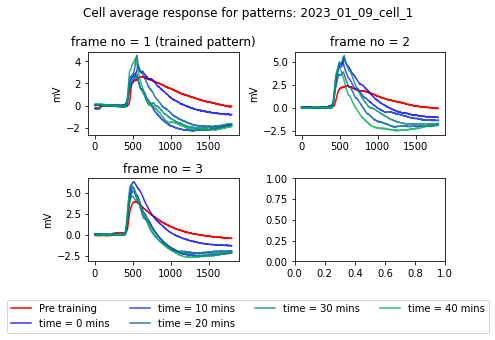

 sp = 12


/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_70952/4247018679.py:128: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()#rect=[0, 0.03, 1, 0.95])#pad=0.4, w_pad=0.5, h_pad=1.0)


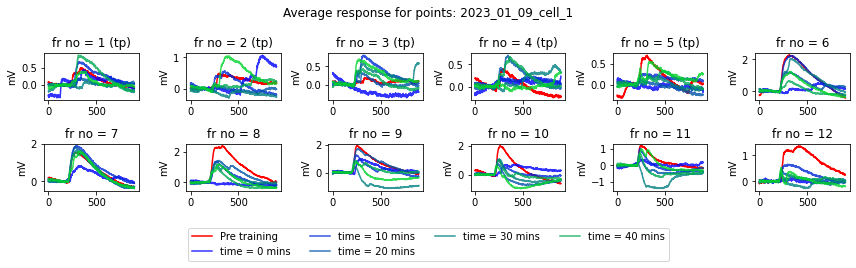

 out for save = /Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp/raw_plots/2023_01_09_cell_2


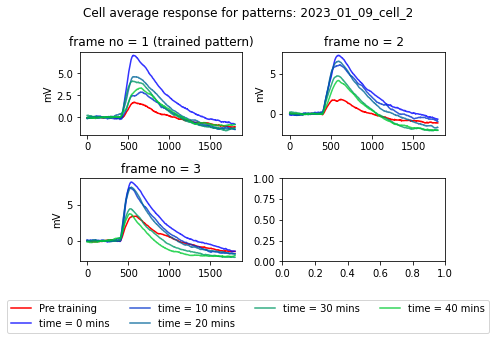

 sp = 12


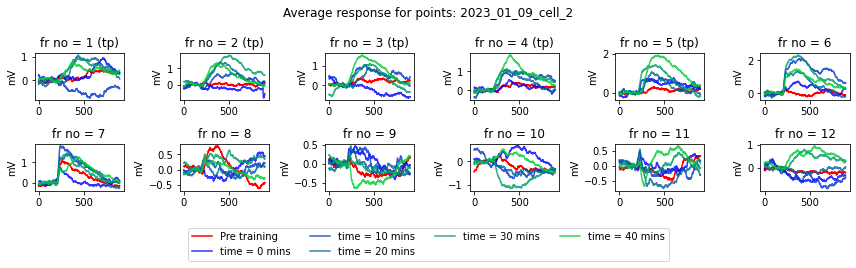

In [349]:
cells = list_folder(p)
#paired = []
for c in cells[-3:-1]:
    try:
        #classic_ltp_plot_patterns(c,outdir)
        #classic_ltp_plot_patterns_average(c,outdir)
        cell_raw_trace_average_plot(c,outdir)
        #field_trace_average_plot(c,outdir)
        #cell_raw_trace_plot(c,outdir)
        #field_raw_trace_plot(c,outdir)
    except Exception as e: print(e)


In [28]:
#plot_pat_vs_sum_p_cells(cells)
cells = list_folder(p)

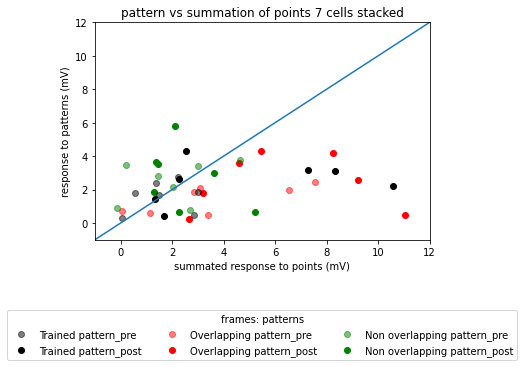

In [29]:
plot_pat_vs_sum_p_cells(cells,outdir)

 out for save = /Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp/raw_plots


/var/folders/sc/cpss_44j20qbqjd8khtbyldc0000gn/T/ipykernel_70952/2888312555.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scatter_post=np.array(scatter_post)


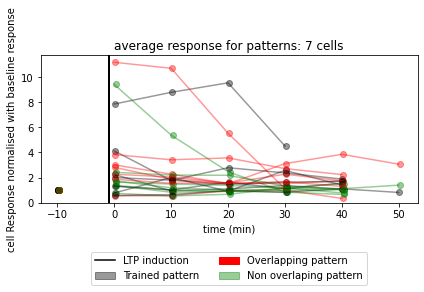

In [30]:
classic_ltp_plot_patterns_average_all_cells(cells,outdir)

cell /Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp/2022_12_19_cell_2 has an error
cell /Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp/2022_12_19_cell_3 has an error
cell /Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp/2022_12_21_cell_1 has an error
cell /Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp/2022_12_30_cell_1 has an error
cell /Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp/2023_01_09_cell_1 has an error
cell /Users/anzalks/Documents/Expt_data/Recordings/CA1_recordings/x_spread_recording_02Hz_30mins/cells_cumulated/cells_with_ltp/2023_01_09_cell_2 has an error
cell /Users/anzalks/Documents/Expt_data/Record

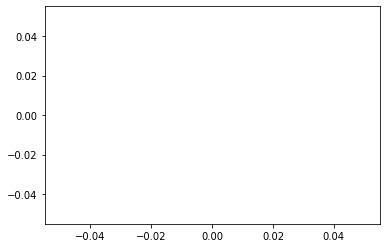

In [31]:
for c in cells:
    try:
        pat_vs_sum_points_plot(c)
        #cell_raw_trace_average_plot(c,outdir)
    except:
        print(f'cell {c} has an error')
        continue
plt.show()

In [32]:
"""
global scatter_pre
    global scatter_post
    global line_post
"""

'\nglobal scatter_pre\n    global scatter_post\n    global line_post\n'

In [33]:
scatter_pre

array([[[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]]])

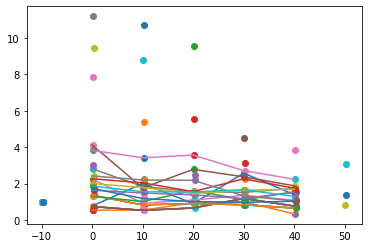

In [34]:
for i in scatter_pre:
    for t in i:
        plt.scatter(t[0],t[1])
for i in scatter_post:
    for n in i:
        for w in n:
            plt.scatter(w[0],w[1])
for i in line_post:
    for n in i:
        plt.plot(n[0],n[1])
plt.show()

In [35]:
scatter_post

array([list([[array([0.1       , 0.76764321]), array([0.2       , 0.54217654]), array([0.3       , 0.74319535])], [array([10.1      ,  2.0071938]), array([10.2       ,  0.55156529]), array([10.3       ,  0.53588468])], [array([20.1       ,  0.90620893]), array([20.2       ,  0.94128656]), array([20.3       ,  0.66254866])], [array([30.1       ,  2.57311535]), array([30.2       ,  1.00226665]), array([30.3       ,  1.18362045])], [array([40.1       ,  1.40021825]), array([40.2       ,  0.33736056]), array([40.3       ,  0.76994812])]]),
       list([[array([0.1       , 7.86082363]), array([ 0.2     , 11.188241]), array([0.3       , 9.41947269])], [array([10.1       ,  8.79365063]), array([10.2       , 10.71028519]), array([10.3       ,  5.38448906])], [array([20.1       ,  9.55106926]), array([20.2       ,  5.53325939]), array([20.3       ,  2.46784234])], [array([30.1       ,  4.51313257]), array([30.2       ,  1.11260533]), array([30.3       ,  0.84811246])]]),
       list([[array([0.

In [36]:
sc_pre_mean =np.mean(scatter_pre, axis=1)

In [37]:
z = np.dstack(sc_pre_mean)

In [38]:
z

array([[[-9.8, -9.8, -9.8, -9.8, -9.8, -9.8, -9.8],
        [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ]]])

In [40]:
z

array([[[-9.8, -9.8, -9.8, -9.8, -9.8, -9.8, -9.8],
        [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ]]])

In [41]:
ar_sc_post=[]
for i in scatter_post:
    if len(i)<4:
        i_ = np.array(i)
        print(f'i = {i_}')
    else:
        i_ = np.array(i[0:4])
    ar_sc_post.append(i_)

In [42]:
ar_sc_post_st = np.vstack(ar_sc_post)

In [43]:
ar_sc_post_st_mn = np.mean(ar_sc_post_st,axis=1)

In [44]:
ar_sc_post_st_mn

array([[ 0.2       ,  0.68433837],
       [10.2       ,  1.03154792],
       [20.2       ,  0.83668139],
       [30.2       ,  1.58633415],
       [ 0.2       ,  9.48951244],
       [10.2       ,  8.29614162],
       [20.2       ,  5.85072366],
       [30.2       ,  2.15795012],
       [ 0.2       ,  2.14196861],
       [10.2       ,  1.20384705],
       [20.2       ,  1.18952986],
       [30.2       ,  1.23938318],
       [ 0.2       ,  1.65361873],
       [10.2       ,  1.31088452],
       [20.2       ,  1.11859127],
       [30.2       ,  1.69175094],
       [ 0.2       ,  1.74146827],
       [10.2       ,  1.51502399],
       [20.2       ,  1.52151334],
       [30.2       ,  1.5207233 ],
       [ 0.2       ,  3.46087686],
       [10.2       ,  2.46022614],
       [20.2       ,  2.84328421],
       [30.2       ,  2.13887652],
       [ 0.2       ,  1.86698874],
       [10.2       ,  1.50911903],
       [20.2       ,  1.33628837],
       [30.2       ,  1.42615718]])

In [ ]:
for i in scatter_pre:
    for tx,t in enumerate(i):
        plt.scatter(t[0],t[1],color=pat_c[tx])
for i in scatter_post:
    for n in i:
        for wx,w in enumerate(n):
            plt.scatter(w[0],w[1],color=pat_c[wx],alpha=0.4)
for i in line_post:
    for nx,n in enumerate(i):
        plt.plot(n[0],n[1],color=pat_c[nx],alpha=0.4)
"""for i in ar_sc_post_mean:
    for n in i:
        plt.scatter(n[0],n[1])
"""

In [45]:
pd_sc_post

NameError: name 'pd_sc_post' is not defined

In [ ]:
pd_sc_post_tr = pd_sc_post.transpose

In [ ]:
pd_sc_post[0].values

In [46]:
scatter_pre

array([[[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]],

       [[-9.9,  1. ],
        [-9.8,  1. ],
        [-9.7,  1. ]]])

In [48]:
scatter_post_pd=pd.DataFrame(scatter_post)

In [69]:
scatter_post_pd[0]

0    [[[0.1, 0.7676432132720947], [0.2, 0.542176544...
1    [[[0.1, 7.860823631286621], [0.2, 11.188241004...
2    [[[0.1, 2.2478983402252197], [0.2, 2.812770843...
3    [[[0.1, 0.5724273920059204], [0.2, 3.012060642...
4    [[[0.1, 1.3110120296478271], [0.2, 2.267116546...
5    [[[0.1, 4.126863479614258], [0.2, 3.8323757648...
6    [[[0.1, 2.0045976638793945], [0.2, 1.862371802...
Name: 0, dtype: object

In [72]:
scatter_post_pd_t= scatter_post_pd[0].transpose()

In [76]:
scatter_post_pd_t_t = scatter_post_pd_t.transpose()

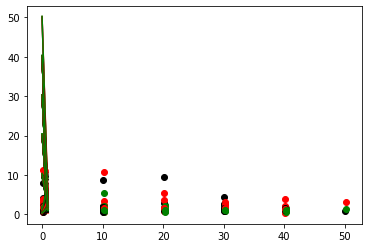

In [103]:

for nx,n in enumerate(scatter_post_pd_t_t):
    for i in n:
        for yx,y in enumerate(i):
            plt.scatter(np.mean(y[0]),np.mean(y[1]),color=pat_c[yx])
            plt.plot(y.transpose(),color=pat_c[yx])

In [148]:
scatter_post_m = np.mean(scatter_post[0],axis=1)

In [149]:
scatter_post_m

array([[ 0.2       ,  0.68433837],
       [10.2       ,  1.03154792],
       [20.2       ,  0.83668139],
       [30.2       ,  1.58633415],
       [40.2       ,  0.83584231]])

p1 =[0.76764321 2.0071938  0.90620893 2.57311535 1.40021825]
p2 =[0.54217654 0.55156529 0.94128656 1.00226665 0.33736056]
p3 =[0.74319535 0.53588468 0.66254866 1.18362045 0.76994812]
p1 =[7.86082363 8.79365063 9.55106926 4.51313257]
p2 =[11.188241   10.71028519  5.53325939  1.11260533]
p3 =[9.41947269 5.38448906 2.46784234 0.84811246]
p1 =[2.24789834 0.93216455 1.0956701  1.3600626  1.0834533 ]
p2 =[2.81277084 1.84723306 1.56201005 1.51825154 1.7442311 ]
p3 =[1.36523664 0.83214355 0.91090941 0.83983541 0.65790689]
p1 =[0.57242739 0.6411953  0.9678182  0.82636458 1.10252118 0.8127169 ]
p2 =[3.01206064 2.26952124 1.50498664 3.1106329  3.8529532  3.06805992]
p3 =[1.37636817 1.02193701 0.88296896 1.13825536 1.10963869 1.39527881]
p1 =[1.31101203 1.01682723 1.62119138 1.11435378 1.54925454]
p2 =[2.26711655 2.0433104  1.56143498 2.26600456 1.74964881]
p3 =[1.64627624 1.48493433 1.38191366 1.18181157 1.52548885]
p1 =[4.12686348 1.76476359 2.782655   2.37346888 1.87974679]
p2 =[3.83237576 3.41

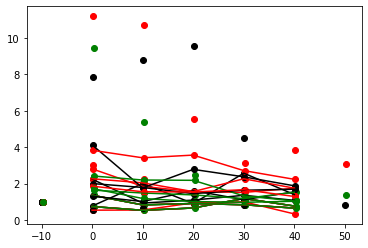

In [215]:
for i in scatter_pre:
    for tx,t in enumerate(i):
        plt.scatter(t[0],t[1],color=pat_c[tx])
p1_c = []
p2_c =[]
p3_c=[]
for i in scatter_post:
    p1 = []
    p2 = []
    p3 = []
    for n in i:
        for wx,w in enumerate(n):
            plt.scatter(w[0],w[1],color=pat_c[wx])
            w_=np.array(w[1])
            if wx==0:
                p1.append(w_)
            if wx ==1:
                p2.append(w_)
            if wx ==2:
                p3.append(w_)
    p1=np.array(p1)
    p1_c.append(p1)
    print(f'p1 ={p1}')
    p2=np.array(p2)
    p2_c.append(p2)
    print(f'p2 ={p2}')
    p3=np.array(p3)
    p3_c.append(p3)
    print(f'p3 ={p3}')
p1_c
print(f'p1_c = {p1_c}')
    #plt.plot(p1[0],color='b')
for i in line_post:
    for nx, n in enumerate(i):
        plt.plot(n[0],n[1],color=pat_c[nx])
plt.show()

In [213]:
min0 = []
min10=[]
min20 = []
min30=[]
min40 = []
min50=[]
for ix,i in enumerate(p1_c):
    min0.append(i[0])
    min10.append(i[1])
    min20.append(i[2])
    min30.append(i[3])
    #min40.append(i[4])

In [209]:
min_0 = np.mean(min0)
min_10 = np.mean(min10)

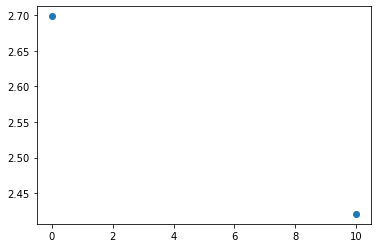

In [210]:
plt.scatter([0,10],[min_0,min_10])

In [242]:
p1_c_pd =pd.DataFrame(p1_c)
p2_c_pd =pd.DataFrame(p2_c)
p3_c_pd =pd.DataFrame(p3_c)

In [252]:
p1_c_pd_m = p1_c_pd.mean(axis=1)
p2_c_pd_m = p2_c_pd.mean(axis=1)
p3_c_pd_m = p3_c_pd.mean(axis=1)

In [253]:
#p1_c_pd_m
#p2_c_pd_m
p3_c_pd_m

0    0.779039
1    4.529979
2    0.921206
3    1.154075
4    1.444085
5    1.835623
6    1.188251
dtype: float64

p1 =[0.76764321 2.0071938  0.90620893 2.57311535 1.40021825]
p2 =[0.54217654 0.55156529 0.94128656 1.00226665 0.33736056]
p3 =[0.74319535 0.53588468 0.66254866 1.18362045 0.76994812]
p1 =[7.86082363 8.79365063 9.55106926 4.51313257]
p2 =[11.188241   10.71028519  5.53325939  1.11260533]
p3 =[9.41947269 5.38448906 2.46784234 0.84811246]
p1 =[2.24789834 0.93216455 1.0956701  1.3600626  1.0834533 ]
p2 =[2.81277084 1.84723306 1.56201005 1.51825154 1.7442311 ]
p3 =[1.36523664 0.83214355 0.91090941 0.83983541 0.65790689]
p1 =[0.57242739 0.6411953  0.9678182  0.82636458 1.10252118 0.8127169 ]
p2 =[3.01206064 2.26952124 1.50498664 3.1106329  3.8529532  3.06805992]
p3 =[1.37636817 1.02193701 0.88296896 1.13825536 1.10963869 1.39527881]
p1 =[1.31101203 1.01682723 1.62119138 1.11435378 1.54925454]
p2 =[2.26711655 2.0433104  1.56143498 2.26600456 1.74964881]
p3 =[1.64627624 1.48493433 1.38191366 1.18181157 1.52548885]
p1 =[4.12686348 1.76476359 2.782655   2.37346888 1.87974679]
p2 =[3.83237576 3.41

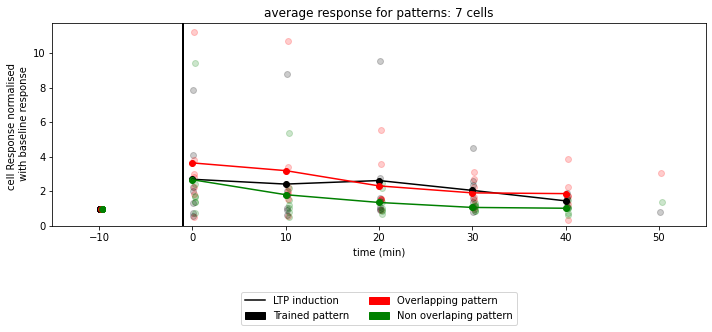

In [335]:
plt.figure(figsize=(10, 5))
for i in scatter_pre:
    for tx,t in enumerate(i):
        plt.scatter(t[0],t[1],color=pat_c[tx])
p1_c = []
p2_c =[]
p3_c=[]
for i in scatter_post:
    p1 = []
    p2 = []
    p3 = []
    for n in i:
        for wx,w in enumerate(n):
            plt.scatter(w[0],w[1],color=pat_c[wx],alpha=0.2)
            w_=np.array(w[1])
            if wx==0:
                p1.append(w_)
            if wx ==1:
                p2.append(w_)
            if wx ==2:
                p3.append(w_)
    p1=np.array(p1)
    p1_c.append(p1)
    print(f'p1 ={p1}')
    p2=np.array(p2)
    p2_c.append(p2)
    print(f'p2 ={p2}')
    p3=np.array(p3)
    p3_c.append(p3)
    print(f'p3 ={p3}')
    #plt.plot(p1[0],color='b')

p1_c_pd =pd.DataFrame(p1_c)
p2_c_pd =pd.DataFrame(p2_c)
p3_c_pd =pd.DataFrame(p3_c)
p1_c_pd_m = p1_c_pd.mean()#axis=1)
p2_c_pd_m = p2_c_pd.mean()#axis=1)
p3_c_pd_m = p3_c_pd.mean()#axis=1)
p1_c_pd_m = p1_c_pd_m#/p1_c_pd_m[0]
p2_c_pd_m = p2_c_pd_m#/p2_c_pd_m[0]
p3_c_pd_m = p3_c_pd_m#/p3_c_pd_m[0]
"""
for i in line_post:
    for nx, n in enumerate(i):
        plt.plot(n[0],n[1],color=pat_c[nx])
"""
#plt.plot(p1_c_pd)
plt.plot(np.arange(0,len(p1_c_pd_m)*10,10)[0:5],p1_c_pd_m[0:5],color='k')
plt.scatter(np.arange(0,len(p1_c_pd_m)*10,10)[0:5],p1_c_pd_m[0:5],color='k')
#plt.plot(p2_c_pd)
plt.plot(np.arange(0,len(p2_c_pd_m)*10,10)[0:5],p2_c_pd_m[0:5],color='r')
plt.scatter(np.arange(0,len(p2_c_pd_m)*10,10)[0:5],p2_c_pd_m[0:5],color='r')
#plt.plot(p3_c_pd)
plt.plot(np.arange(0,len(p3_c_pd_m)*10,10)[0:5],p3_c_pd_m[0:5],color='g')
plt.scatter(np.arange(0,len(p3_c_pd_m)*10,10)[0:5],p3_c_pd_m[0:5],color='g')
plt.title(f'average epsp response combined for {len(scatter_pre)} cells')
legend_elements = [Line2D([0], [0], color='k', lw=1.5, label='LTP induction'),mpatches.Patch(color='black', label='Trained pattern'),
                   mpatches.Patch(color='red', label='Overlapping pattern'),mpatches.Patch(color='green', label='Non overlaping pattern')]
    
plt.axvline(-1, color='k',linewidth=2)
plt.legend(loc='upper center',bbox_to_anchor =(0.5, -0.3), ncol = 2,handles=legend_elements)    
plt.ylim(ymin=0)
#plt.ylim(0,6)
plt.xlim(-15,55)
#plt.ylim(0,15)
plt.xlabel('time (min)')
plt.ylabel('cell Response normalised \n with baseline response')
#plt.ylabel('cell Response (mV)')
plt.title(f'average response for patterns: {len(cells)} cells')
plt.tight_layout()
plt.savefig(f'{outdir}/all_cells_classic_LTP_average_patterns_norm_baseline_final_no_ylim_no_xlim.png',bbox_inches='tight')    
plt.show()
plt.close()